
# Taxi Revenue per Zone – Linear Regression (historical)
Vorhersage und Ranking der lukrativsten Zonen basierend auf historischen Taxi- und Wetterdaten.


Nachdem wir die Daten bereinigt haben, erstellen wir zunächst ein Baseline-Modell. Die Lineare Regression wird oft übersehen, da sie vergleichsweise simpel zu verstehen ist, sie kann aber oft unvorhergesehen gute Ergebnisse liefern (jedoch nicht in unserem usecase, da wir keine linearen daten haben). Unser Ziel ist es zu verstehen, wie stark die Fahrstrecke (trip_distance) allein den Fahrpreis (fare_amount) erklären kann. Wir erwarten hier einen starken linearen Zusammenhang, wissen aber, dass Faktoren wie Verkehrsdichte und Festpreise (z.B. zum JFK-Flughafen) dieses Bild verzerren können.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Load merged taxi + weather data
df = pd.read_csv("../data/taxi_weather_merged-2.csv")
df["pickup_hour"] = pd.to_datetime(df["pickup_hour"])
df = df.sort_values(["pickup_hour"]).reset_index(drop=True)

target = "log_revenue"
print("Umsatz-Median: ", df["revenue"].mean(), "$")

Umsatz-Median:  2481.4120961388708 $


MAE train: 1373.797942119317
MAE test : 1337.8310977629653
MSE train: 2618985.303625274
MSE test : 2488418.794096202


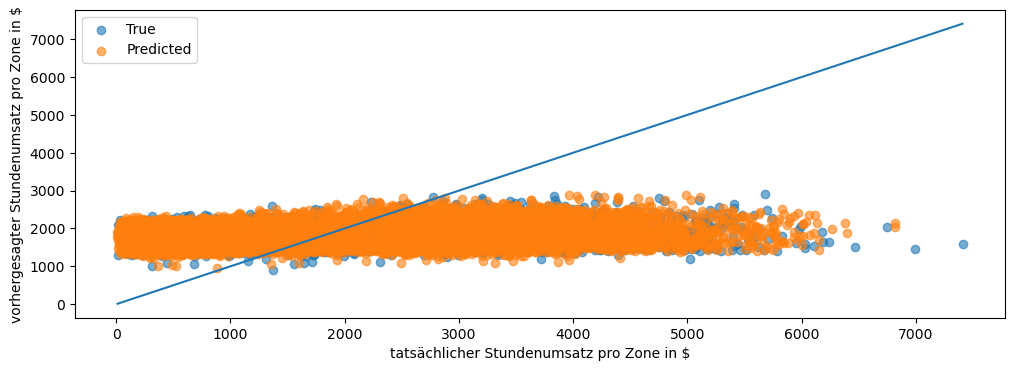

In [30]:
# Daten laden
features = ["temperature_2m (°C)", "precipitation (mm)"]

data = df[features + [target]].dropna()
X = data[features].values
y_log = data[target].values

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.7, random_state=42)


# Modell trainieren
model = LinearRegression()
model.fit(X_train, y_train_log)

y_hat_train_log = model.predict(X_train)
y_hat_test_log = model.predict(X_test)

y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)
y_hat_train = np.expm1(y_hat_train_log)
y_hat_test = np.expm1(y_hat_test_log)

mae_train = mean_absolute_error(y_train, y_hat_train)
mae_test = mean_absolute_error(y_test,  y_hat_test)
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test,  y_hat_test)

print("MAE train:", mae_train)
print("MAE test :", mae_test)
print("MSE train:", mse_train)
print("MSE test :", mse_test)

fig, ax = plt.subplots(figsize=(12, 4))

ax.scatter(y_train, y_hat_train, label="True", alpha=0.6)
ax.scatter(y_test,  y_hat_test,  label="Predicted",  alpha=0.6)

min_val = min(y_train.min(), y_hat_train.min(), y_hat_test.min())
max_val = max(y_train.max(), y_hat_train.max(), y_hat_test.max())
ax.plot([min_val, max_val], [min_val, max_val])

ax.set_xlabel("tatsächlicher Stundenumsatz pro Zone in $")
ax.set_ylabel("vorhergesagter Stundenumsatz pro Zone in $")
ax.legend()

plt.show()

In [5]:
from sklearn.metrics import r2_score

print("R2 train:", r2_score(y_train, y_hat_train))
print("R2 test :", r2_score(y_test,  y_hat_test))

# Naiver Baseline-Vergleich: immer Mittelwert vorhersagen
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
print("MAE baseline:", mae_baseline)

R2 train: -0.17133200651038338
R2 test : -0.17358994513654968
MAE baseline: 1265.9486801607184


In [9]:
# erst sortieren
df = df.sort_values("pickup_hour")

# revenue schon definiert?
df["revenue"] = df["trip_count"] * (df["mean_fare"] + df["mean_tip"])

# Lags erzeugen
df["revenue_lag_1"] = df["revenue"].shift(1)
df["revenue_lag_24"] = df["revenue"].shift(24)

# Rolling-Mean (7 Tage à 24h)
df["revenue_mean_7d"] = (
    df["revenue"]
      .rolling(24*7, min_periods=1)
      .mean()
)


# ---------------------------------------------------------
# Features und Target aus city-level df
# ---------------------------------------------------------

df = df.dropna()

# Target
df["log_revenue"] = np.log1p(df["revenue"])
target = "log_revenue"
print(df["log_revenue"].mean())

# numerische Features (kein PULocationID mehr)
num_cols = [
    "temperature_2m (°C)",
    "precipitation (mm)",
    "sunshine_duration (s)",
    "snowfall (mm)",
    "snow_depth (mm)",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "is_weekend",
    "revenue_lag_1",
    "revenue_lag_24",
    "revenue_mean_7d",
]
features = num_cols

X = df[features]
y_log = df[target]

# Zeitlicher Split (empfohlen)
split_date = "2023-11-01"
train = df[df["pickup_hour"] < split_date]
test  = df[df["pickup_hour"] >= split_date]

X_train = train[features]
y_train = train[target]
X_test  = test[features]
y_test  = test[target]

# ---------------------------------------------------------
# Modelle
# ---------------------------------------------------------
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
    ]
)

models = {
    "OLS":   LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.0005, max_iter=10000),
}

for name, base_model in models.items():
    pipe = Pipeline(steps=[
        ("prep", preprocess),
        ("model", base_model),
    ])
    
    pipe.fit(X_train, y_train)
    y_hat_train = pipe.predict(X_train)
    y_hat_test  = pipe.predict(X_test)

    # zurück in Originalskala
    yt = np.expm1(y_train.to_numpy())
    yp_tr = np.expm1(y_hat_train)
    yp_te = np.expm1(y_hat_test)

    print(name)
    print("MAE train:", mean_absolute_error(yt, yp_tr))
    print("MAE test :", mean_absolute_error(np.expm1(y_test), yp_te))
    print()

7.486043927179187
OLS
MAE train: 736.6208126390371
MAE test : 972.9722054408217

Ridge
MAE train: 736.5780268404108
MAE test : 972.8847853487907

Lasso
MAE train: 736.035730887835
MAE test : 971.5952156773079



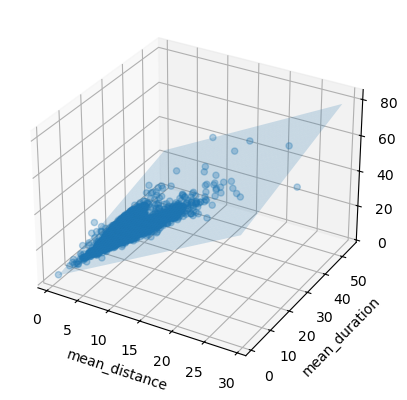

In [ ]:
# Daten wählen
# city-level df mit Spalten:
# "mean_distance", "mean_duration", "mean_fare"
df_plot = df[["mean_distance", "mean_duration", "mean_fare"]].dropna()

X = df_plot[["mean_distance", "mean_duration"]]
y = df_plot["mean_fare"]

# Modell fitten
model = LinearRegression()
model.fit(X, y)

# Grid + Vorhersagen
x_range = np.linspace(X["mean_distance"].min(), X["mean_distance"].max(), 50)
y_range = np.linspace(X["mean_duration"].min(), X["mean_duration"].max(), 50)
xx, yy = np.meshgrid(x_range, y_range)

grid_df = pd.DataFrame({
    "mean_distance": xx.ravel(),
    "mean_duration": yy.ravel(),
})
zz = model.predict(grid_df).reshape(xx.shape)

# Plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    X["mean_distance"],
    X["mean_duration"],
    y,
    alpha=0.3
)

ax.plot_surface(xx, yy, zz, alpha=0.2)

ax.set_xlabel("mean_distance")
ax.set_ylabel("mean_duration")
ax.set_zlabel("mean_fare")

plt.tight_layout()
plt.show()

R² : 0.8727566012161783
MSE: 2.9585102683445457
MAE: 1.3883824400304114


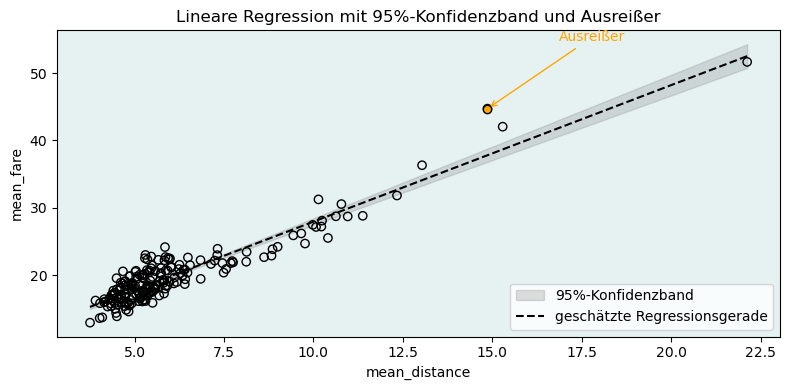

In [ ]:
import statsmodels.api as sm

df_plot = df[["mean_distance", "mean_fare"]].dropna().copy()
df_plot = df_plot[df_plot["mean_distance"] < 60]  # optionales Trimmen

df_plot = df_plot.sample(min(len(df_plot), 200), random_state=0)

x = df_plot["mean_distance"].to_numpy()
y = df_plot["mean_fare"].to_numpy()

# OLS fitten
X = sm.add_constant(x) # Intercept
model = sm.OLS(y, X).fit()

x_grid = np.linspace(x.min(), x.max(), 200)
X_grid = sm.add_constant(x_grid)

pred = model.get_prediction(X_grid)
pred_ci = pred.summary_frame(alpha=0.05)  # 95% Konfidenzband der Regressionsgeraden

y_line  = pred_ci["mean"].to_numpy()
y_lower = pred_ci["mean_ci_lower"].to_numpy()
y_upper = pred_ci["mean_ci_upper"].to_numpy()

y_hat   = model.predict(X)

r2  = r2_score(y, y_hat)
mse = mean_squared_error(y, y_hat)
mae = mean_absolute_error(y, y_hat)

print("R² :", r2)
print("MSE:", mse)
print("MAE:", mae)

resid   = y - y_hat
out_idx = np.argmax(np.abs(resid))
x_out, y_out = x[out_idx], y[out_idx]

# Plot
fig, ax = plt.subplots(figsize=(8,4))
ax.set_facecolor("#e6f2f2")

# Konfidenzband
ax.fill_between(x_grid, y_lower, y_upper, color="gray", alpha=0.25, label="95%-Konfidenzband")

# Regressionsgerade
ax.plot(x_grid, y_line, "k--", label="geschätzte Regressionsgerade")

ax.scatter(x, y, facecolors="none", edgecolors="black")

# Ausreißer hervorheben
ax.scatter(x_out, y_out, color="orange", edgecolors="black", zorder=5)
ax.annotate("Ausreißer", xy=(x_out, y_out), xytext=(x_out + 2, y_out + 10), arrowprops=dict(arrowstyle="->", color="orange"), color="orange")

ax.set_xlabel("mean_distance")
ax.set_ylabel("mean_fare")
ax.set_title("Lineare Regression mit 95%-Konfidenzband und Ausreißer")

ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

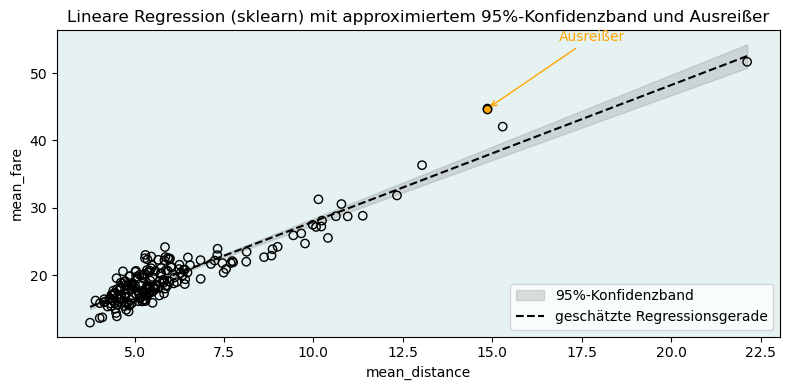

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

df_plot = df[["mean_distance", "mean_fare"]].dropna().copy()
df_plot = df_plot[df_plot["mean_distance"] < 60]
df_plot = df_plot.sample(min(len(df_plot), 200), random_state=0)

x = df_plot["mean_distance"].to_numpy().reshape(-1,1)
y = df_plot["mean_fare"].to_numpy()

model = LinearRegression()
model.fit(x, y)
x_grid = np.linspace(x.min(), x.max(), 200).reshape(-1,1)
y_hat_grid = model.predict(x_grid)

# Residuen
y_hat = model.predict(x)
resid = y - y_hat
sigma2 = np.var(resid, ddof=1)

# Standardfehler und einfache Approximation
x_flat = x.flatten()
Sxx = np.sum((x_flat - x_flat.mean())**2)

se = np.sqrt(
    sigma2 * (
        1/len(x_flat) +
        (x_grid.flatten() - x_flat.mean())**2 / Sxx
    )
)

ci = 1.96 * se
y_lower = y_hat_grid - ci
y_upper = y_hat_grid + ci

# Ausreißer
resid_full = resid
out_idx = np.argmax(np.abs(resid_full))
x_out = x_flat[out_idx]
y_out = y[out_idx]

# Plot
fig, ax = plt.subplots(figsize=(8,4))
ax.set_facecolor("#e6f2f2")

ax.fill_between(
    x_grid.flatten(), y_lower, y_upper,
    color="gray", alpha=0.25, label="95%-Konfidenzband"
)

ax.plot(x_grid, y_hat_grid, "k--", label="geschätzte Regressionsgerade")

ax.scatter(x_flat, y, facecolors="none", edgecolors="black")

ax.scatter(x_out, y_out, color="orange", edgecolors="black", zorder=5)
ax.annotate("Ausreißer", xy=(x_out, y_out), xytext=(x_out + 2, y_out + 10), arrowprops=dict(arrowstyle="->", color="orange"), color="orange")

ax.set_xlabel("mean_distance")
ax.set_ylabel("mean_fare")
ax.set_title("Lineare Regression mit approximiertem 95%-Konfidenzband und Ausreißer")
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


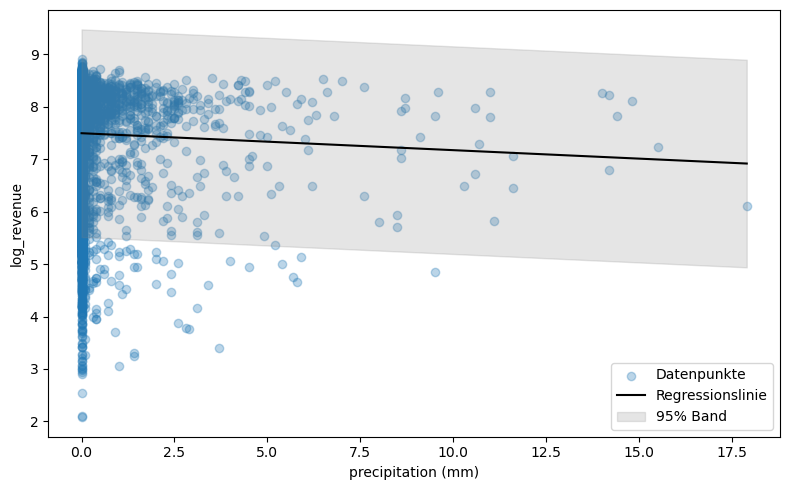

In [ ]:
# Daten auswählen und NaN entfernen
df_plot = df[["precipitation (mm)", "log_revenue"]].dropna()

X = df_plot[["precipitation (mm)"]]
y = df_plot["log_revenue"]

model = LinearRegression()
model.fit(X, y)

# Bereich für X
x_vals = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
y_pred = model.predict(x_vals)

# Residuen Standardfehler zur Bandbreite
y_hat = model.predict(X)
residuals = y - y_hat
sigma = residuals.std()

# 95%-Konfidenzband approximiert: ± 1.96*sigma
upper = y_pred + 1.96 * sigma
lower = y_pred - 1.96 * sigma

# Plot
plt.figure(figsize=(8,5))
plt.scatter(X, y, alpha=0.3, label="Datenpunkte", color="#1f77b4")

# Regression
plt.plot(x_vals, y_pred, label="Regressionslinie", color="black")

# Band
plt.fill_between(
    x_vals.flatten(),
    lower,
    upper,
    alpha=0.2,
    color="gray",
    label="95% Band"
)

plt.xlabel("precipitation (mm)")
plt.ylabel("log_revenue")
plt.legend()
plt.tight_layout()
plt.show()

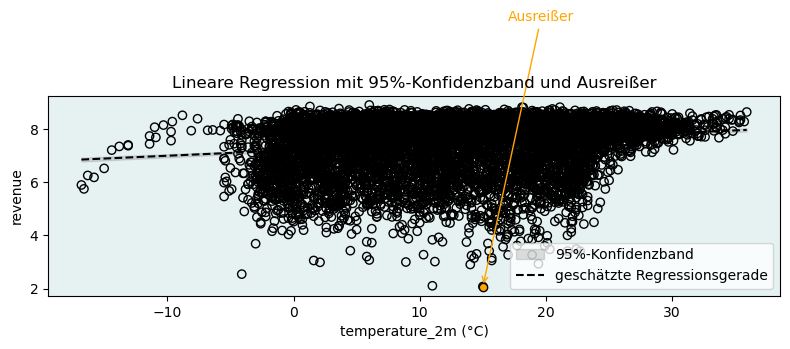

In [ ]:
import statsmodels.api as sm

df_plot = df[["temperature_2m (°C)", "log_revenue"]].dropna().copy()


x = df["temperature_2m (°C)"].to_numpy().reshape(-1,1)
y = df["log_revenue"].to_numpy()

# 2) OLS fitten
X = sm.add_constant(x)# Intercept
model = sm.OLS(y, X).fit()

x_grid = np.linspace(x.min(), x.max(), 200)
X_grid = sm.add_constant(x_grid)

pred = model.get_prediction(X_grid)
pred_ci = pred.summary_frame(alpha=0.05)  # 95% Konfidenzband der Regressionsgeraden

y_line  = pred_ci["mean"].to_numpy()
y_lower = pred_ci["mean_ci_lower"].to_numpy()
y_upper = pred_ci["mean_ci_upper"].to_numpy()

y_hat   = model.predict(X)
resid   = y - y_hat
out_idx = np.argmax(np.abs(resid))
x_out, y_out = x[out_idx], y[out_idx]

# Plot
fig, ax = plt.subplots(figsize=(8,4))

ax.set_facecolor("#e6f2f2")

# Konfidenzband
ax.fill_between(x_grid, y_lower, y_upper, color="gray", alpha=0.25, label="95%-Konfidenzband")

# Regressionsgerade
ax.plot(x_grid, y_line, "k--", label="geschätzte Regressionsgerade")

# Punkte
ax.scatter(x, y, facecolors="none", edgecolors="black")

# Ausreißer hervorheben
ax.scatter(x_out, y_out, color="orange", edgecolors="black", zorder=5)
ax.annotate("Ausreißer", xy=(x_out, y_out), xytext=(x_out + 2, y_out + 10), arrowprops=dict(arrowstyle="->", color="orange"), color="orange")

ax.set_xlabel("temperature_2m (°C)")
ax.set_ylabel("revenue")
ax.set_title("Lineare Regression mit 95%-Konfidenzband und Ausreißer")

ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

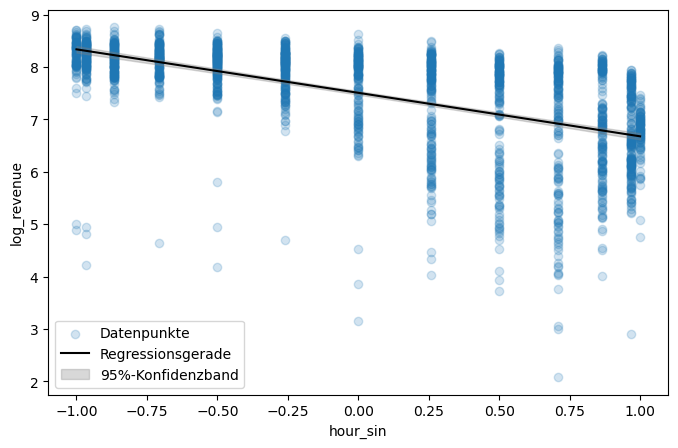

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

df_plot = df[["hour_sin", "log_revenue"]].dropna()

df_plot = df_plot.sample(min(len(df_plot), 2000), random_state=0)

x = df_plot["hour_sin"].to_numpy()
y = df_plot["log_revenue"].to_numpy()

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

x_grid = np.linspace(x.min(), x.max(), 200)
X_grid = sm.add_constant(x_grid)
pred = model.get_prediction(X_grid)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y, alpha=0.2, label="Datenpunkte")
ax.plot(x_grid, pred_mean, color="black", label="Regressionsgerade")
ax.fill_between(x_grid, pred_ci[:,0], pred_ci[:,1], color="gray", alpha=0.3, label="95%-Konfidenzband")

ax.set_xlabel("hour_sin")
ax.set_ylabel("log_revenue")
ax.legend()
plt.show()

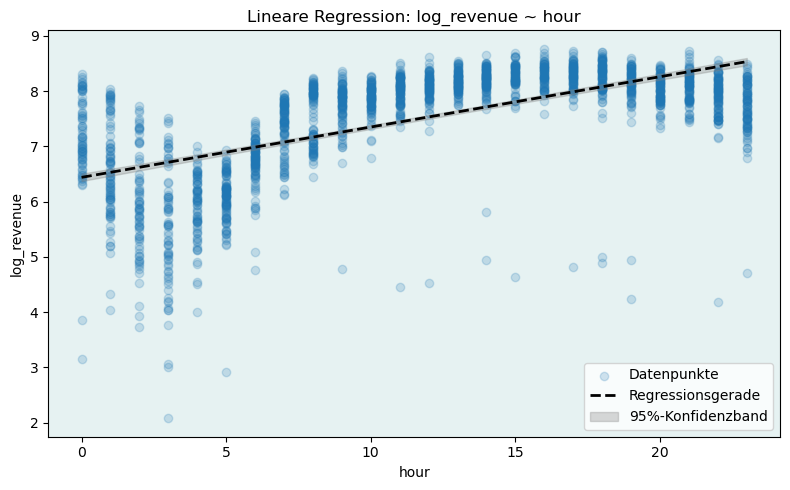

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Stunde aus hour_sin / hour_cos zurückrechnen (habe ich ursprünglich hinzugefügt, damit 23 Uhr nicht natürlich mehr gewichtet wird wie beispielsweise 00:01 nur basierend auf dem numerischen Wert.)

# Winkel (in Grad) aus sin/cos zurückrechnen
angle_deg = np.rad2deg(np.arctan2(df["hour_sin"], df["hour_cos"]))
angle_deg = angle_deg % 360

# Auf 0-24 Stunden abbilden
hour_recon = angle_deg / 360 * 24

# Runden auf ganze Stunden
df["hour"] = np.round(hour_recon).astype(int)
df["hour"] = df["hour"] % 24

# 2. Daten für Regression: log_revenue pro hour
df_plot = df[["hour", "log_revenue"]].dropna().copy()


df_plot = df_plot.sample(min(len(df_plot), 2000), random_state=0)

x = df_plot["hour"].to_numpy().reshape(-1, 1)   # Feature
y = df_plot["log_revenue"].to_numpy()           # Target Variable

# 3. Lineare Regression
model = LinearRegression()
model.fit(x, y)

# Grid von 0..23 Stunden
x_grid = np.linspace(0, 23, 200).reshape(-1, 1)
y_hat_grid = model.predict(x_grid)

y_hat = model.predict(x)
resid = y - y_hat
sigma2 = np.var(resid, ddof=1)

x_flat = x.flatten()
x_mean = x_flat.mean()
Sxx = np.sum((x_flat - x_mean) ** 2)

se = np.sqrt(
    sigma2 * (
        1/len(x_flat) +
        (x_grid.flatten() - x_mean) ** 2 / Sxx
    )
)
ci = 1.96 * se
y_lower = y_hat_grid - ci
y_upper = y_hat_grid + ci

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor("#e6f2f2")

# Punkte
ax.scatter(x_flat, y, alpha=0.2, label="Datenpunkte")

# Regressionslinie
ax.plot(x_grid, y_hat_grid, "k--", linewidth=2, label="Regressionsgerade")

# 95%-Band
ax.fill_between(
    x_grid.flatten(),
    y_lower,
    y_upper,
    color="gray",
    alpha=0.3,
    label="95%-Konfidenzband"
)

ax.set_xlabel("hour")
ax.set_ylabel("log_revenue")
ax.set_title("Lineare Regression: log_revenue ~ hour")
ax.legend()
plt.tight_layout()
plt.show()

In [22]:
print(df.columns.tolist())

['pickup_hour', 'trip_count', 'mean_distance', 'mean_duration', 'mean_speed', 'mean_fare', 'mean_tip', 'mean_passengers', 'temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)', 'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)', 'weather_code (wmo code)', 'cloud_cover (%)', 'wind_speed_10m (km/h)', 'is_day ()', 'sunshine_duration (s)', 'snowfall (mm)', 'snow_depth (mm)', 'hour', 'dow', 'is_weekend', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'revenue', 'log_revenue', 'revenue_lag_1', 'revenue_lag_24', 'revenue_mean_7d']


# Nun mit etwas mehr features (inkl. OneHotEncoding für die Location)

**Weitere Verbesserung:**
> kein prozentueller Split der Daten mehr, sondern nacb Datum (enabled forecasting)

In [1]:
# Daten laden
num_cols = [
    "temperature_2m (°C)",
    "precipitation (mm)",
    "sunshine_duration (s)",
    "snowfall (mm)",
    "snow_depth (mm)",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "is_weekend",
    # später noch OHE für PULocationID
]

cat_cols  = ["PULocationID"]
features = num_cols + cat_cols

data = df[features + [target]].dropna()

X = data[features]
y_log = data[target]

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.7, random_state=42)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

model = LinearRegression()

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model),
])

# Modell trainieren
pipe.fit(X_train, y_train_log)

y_hat_train_log = pipe.predict(X_train)
y_hat_test_log = pipe.predict(X_test)

y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)
y_hat_train = np.expm1(y_hat_train_log)
y_hat_test = np.expm1(y_hat_test_log)

mae_train = mean_absolute_error(y_train, y_hat_train)
mae_test = mean_absolute_error(y_test,  y_hat_test)
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test,  y_hat_test)

print("MAE train:", mae_train)
print("MAE test :", mae_test)
print("MSE train:", mse_train)
print("MSE test :", mse_test)

fig, ax = plt.subplots(figsize=(12, 4))

ax.scatter(y_train, y_hat_train, label="Train", alpha=0.6)
ax.scatter(y_test,  y_hat_test,  label="Test",  alpha=0.6)

min_val = min(y_train.min(), y_hat_train.min(), y_hat_test.min())
max_val = max(y_train.max(), y_hat_train.max(), y_hat_test.max())
ax.plot([min_val, max_val], [min_val, max_val])

ax.set_xlabel("True")
ax.set_ylabel("Predicted")
ax.legend()

plt.show()

NameError: name 'df' is not defined

# Ridge & Lasso


=== OLS ===
MAE train: 37.62347790627523
MAE test : 37.88611987634575
MSE train: 4860.720666721266
MSE test : 5000.97817685504

=== Ridge ===
MAE train: 37.840349349931465
MAE test : 38.10994383146864
MSE train: 5025.0147019470405
MSE test : 5179.388931233243

=== Lasso ===
MAE train: 37.82606117526363
MAE test : 38.09385987333085
MSE train: 4917.6710866571775
MSE test : 5057.760807230559


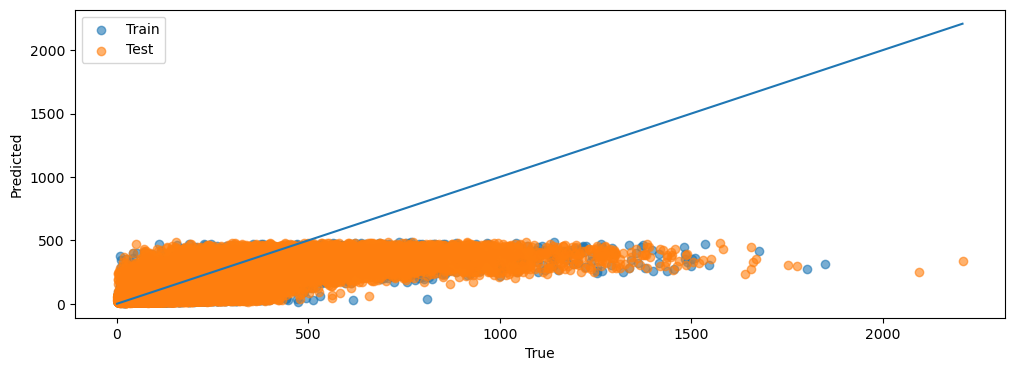

In [ ]:
# -----------------------------
# Features / Target
# -----------------------------
num_cols = [
    "temperature_2m (°C)",
    "precipitation (mm)",
    "sunshine_duration (s)",
    "snowfall (mm)",
    "snow_depth (mm)",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "is_weekend",
]
cat_cols = ["PULocationID"]
features = num_cols + cat_cols

# log-Target (vorher: df["revenue"] definiert)
df["log_revenue"] = np.log1p(df["revenue"])
target = "log_revenue"

data = df[features + [target]].dropna()
X = data[features]          # DataFrame, keine .values
y_log = data[target]        # Series

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.7, random_state=42
)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

models = {
    "OLS"  : LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.0005, max_iter=10000),
}

for name, base_model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", base_model),
    ])

    # Train
    pipe.fit(X_train, y_train_log)

    # Vorhersagen im Log-Space
    y_hat_train_log = pipe.predict(X_train)
    y_hat_test_log = pipe.predict(X_test)

    # Zurück in Originalskala
    y_train = np.expm1(y_train_log.to_numpy())
    y_test = np.expm1(y_test_log.to_numpy())
    y_hat_train = np.expm1(y_hat_train_log)
    y_hat_test = np.expm1(y_hat_test_log)

    mae_train = mean_absolute_error(y_train, y_hat_train)
    mae_test = mean_absolute_error(y_test,  y_hat_test)
    mse_train = mean_squared_error(y_train, y_hat_train)
    mse_test = mean_squared_error(y_test,  y_hat_test)

    print(f"\n=== {name} ===")
    print("MAE train:", mae_train)
    print("MAE test :", mae_test)
    print("MSE train:", mse_train)
    print("MSE test :", mse_test)

# Optional: Plot für eines der Modelle (z.B. Ridge)
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0)),
])
pipe.fit(X_train, y_train_log)
y_hat_train = np.expm1(pipe.predict(X_train))
y_hat_test = np.expm1(pipe.predict(X_test))
y_train = np.expm1(y_train_log.to_numpy())
y_test = np.expm1(y_test_log.to_numpy())

fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(y_train, y_hat_train, label="Train", alpha=0.6)
ax.scatter(y_test,  y_hat_test,  label="Test",  alpha=0.6)

min_val = min(y_train.min(), y_test.min(), y_hat_train.min(), y_hat_test.min())
max_val = max(y_train.max(), y_test.max(), y_hat_train.max(), y_hat_test.max())
ax.plot([min_val, max_val], [min_val, max_val])

ax.set_xlabel("True")
ax.set_ylabel("Predicted")
ax.legend()
plt.show()

# Rolling

MAE train: 38.435812528172455
MAE test : 39.82449902405341

=== Lasso ===
MAE train: 38.435812528172455
MAE test : 39.82449902405341
MSE train: 8069.00207940686
MSE test : 6022.590903948796


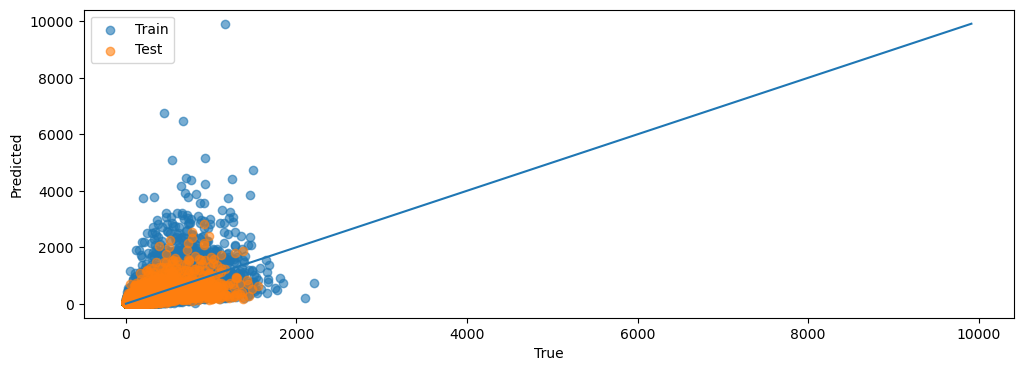

In [ ]:
# Reihenfolge: erst revenue, dann sortieren, dann Lags/Rolling
df["revenue"] = df["trip_count"] * (df["mean_fare"] + df["mean_tip"])

df = df.sort_values(["PULocationID", "pickup_hour"])

df["revenue_lag_1"] = df.groupby("PULocationID")["revenue"].shift(1)
df["revenue_lag_24"] = df.groupby("PULocationID")["revenue"].shift(24)
df["revenue_mean_7d"] = (
    df.groupby("PULocationID")["revenue"]
      .rolling(24*7, min_periods=1)
      .mean()
      .reset_index(level=0, drop=True)
)

# Target im Log-Space
df["log_revenue"] = np.log1p(df["revenue"])
target = "log_revenue"

num_cols = [
    "temperature_2m (°C)",
    "precipitation (mm)",
    "sunshine_duration (s)",
    "snowfall (mm)",
    "snow_depth (mm)",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "is_weekend",
    "revenue_lag_1",
    "revenue_lag_24",
    "revenue_mean_7d",
]

cat_cols = ["PULocationID"]
features = num_cols + cat_cols

data = df[features + [target, "pickup_hour"]].dropna()

X = data[features]
y_log = data[target]

split_date = "2023-11-01"
train = data[data["pickup_hour"] < split_date]
test  = data[data["pickup_hour"] >= split_date]

X_train = train[features]
y_train_log = train[target]
X_test  = test[features]
y_test_log  = test[target]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

model = Ridge(alpha=1.0)  # oder Lasso / OLS

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model),
])

pipe.fit(X_train, y_train_log)

y_hat_train_log = pipe.predict(X_train)
y_hat_test_log  = pipe.predict(X_test)

y_train     = np.expm1(y_train_log.to_numpy())
y_test      = np.expm1(y_test_log.to_numpy())
y_hat_train = np.expm1(y_hat_train_log)
y_hat_test  = np.expm1(y_hat_test_log)


print(f"\n=== Ridge ===")
print("MAE train:", mean_absolute_error(y_train, y_hat_train))
print("MAE test :", mean_absolute_error(y_test, y_hat_test))
print("MSE train:", mean_squared_error(y_train, y_hat_train))
print("MSE test :", mean_squared_error(y_test, y_hat_test))

# Optional: Plot für eines der Modelle (z.B. Ridge)
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0)),
])
pipe.fit(X_train, y_train_log)
y_hat_train = np.expm1(pipe.predict(X_train))
y_hat_test = np.expm1(pipe.predict(X_test))
y_train = np.expm1(y_train_log.to_numpy())
y_test = np.expm1(y_test_log.to_numpy())

fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(y_train, y_hat_train, label="Train", alpha=0.6)
ax.scatter(y_test,  y_hat_test,  label="Test",  alpha=0.6)

min_val = min(y_train.min(), y_test.min(), y_hat_train.min(), y_hat_test.min())
max_val = max(y_train.max(), y_test.max(), y_hat_train.max(), y_hat_test.max())
ax.plot([min_val, max_val], [min_val, max_val])

ax.set_xlabel("True")
ax.set_ylabel("Predicted")
ax.legend()
plt.show()

# Lags


=== OLS ===
MAE train: 38.93781081048466
MAE test : 38.97105592154072
MSE train: 8015.482595777909
MSE test : 9256.428057701367

=== Ridge ===
MAE train: 38.9916073056668
MAE test : 38.99701006340848
MSE train: 7867.909422529074
MSE test : 9045.001187160286

=== Lasso ===
MAE train: 39.4459727097505
MAE test : 39.47138941578157
MSE train: 8871.657745755852
MSE test : 10262.347756255505


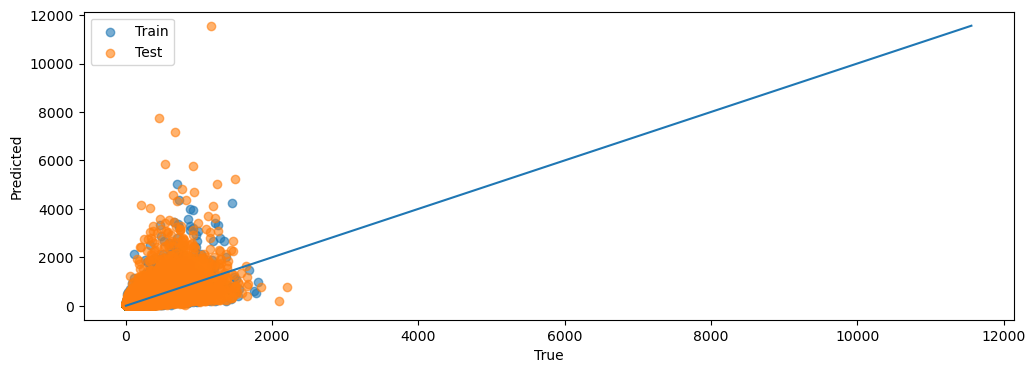

In [ ]:

# Revenue + Lags vorbereiten (einmalig vor dem Modell-Block)
df["revenue"] = df["trip_count"] * (df["mean_fare"] + df["mean_tip"])

# Nach Zone und Zeit sortieren  damit Lags zeitlich korrekt sind
df = df.sort_values(["PULocationID", "pickup_hour"])

# Lag Features pro Zone
df["revenue_lag_1"] = df.groupby("PULocationID")["revenue"].shift(1)
df["revenue_lag_24"] = df.groupby("PULocationID")["revenue"].shift(24)
df["revenue_mean_7d"] = (
    df.groupby("PULocationID")["revenue"]
      .rolling(24*7, min_periods=1)
      .mean()
      .reset_index(level=0, drop=True)
)

# log-Target Varaible
df["log_revenue"] = np.log1p(df["revenue"])
target = "log_revenue"

# 1) Features / Target
num_cols = [
    "temperature_2m (°C)",
    "precipitation (mm)",
    "sunshine_duration (s)",
    "snowfall (mm)",
    "snow_depth (mm)",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "is_weekend",
    # neue Lag-Features:
    "revenue_lag_1",
    "revenue_lag_24",
    "revenue_mean_7d",
]
cat_cols = ["PULocationID"]
features = num_cols + cat_cols

data = df[features + [target]].dropna()

X = data[features]
y_log = data[target]

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.7, random_state=42
)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

models = {
    "OLS"  : LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.0005, max_iter=10000),
}

for name, base_model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", base_model),
    ])

    # Train
    pipe.fit(X_train, y_train_log)

    # Vorhersagen im Log-Space
    y_hat_train_log = pipe.predict(X_train)
    y_hat_test_log  = pipe.predict(X_test)

    # Zurück in Originalskala
    y_train     = np.expm1(y_train_log.to_numpy())
    y_test      = np.expm1(y_test_log.to_numpy())
    y_hat_train = np.expm1(y_hat_train_log)
    y_hat_test  = np.expm1(y_hat_test_log)

    mae_train = mean_absolute_error(y_train, y_hat_train)
    mae_test  = mean_absolute_error(y_test,  y_hat_test)
    mse_train = mean_squared_error(y_train, y_hat_train)
    mse_test  = mean_squared_error(y_test,  y_hat_test)

    print(f"\n=== {name} ===")
    print("MAE train:", mae_train)
    print("MAE test :", mae_test)
    print("MSE train:", mse_train)
    print("MSE test :", mse_test)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0)),
])
pipe.fit(X_train, y_train_log)

y_hat_train = np.expm1(pipe.predict(X_train))
y_hat_test  = np.expm1(pipe.predict(X_test))
y_train     = np.expm1(y_train_log.to_numpy())
y_test      = np.expm1(y_test_log.to_numpy())

fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(y_train, y_hat_train, label="Train", alpha=0.6)
ax.scatter(y_test,  y_hat_test,  label="Test",  alpha=0.6)

min_val = min(y_train.min(), y_test.min(), y_hat_train.min(), y_hat_test.min())
max_val = max(y_train.max(), y_test.max(), y_hat_train.max(), y_hat_test.max())
ax.plot([min_val, max_val], [min_val, max_val])

ax.set_xlabel("True")
ax.set_ylabel("Predicted")
ax.legend()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


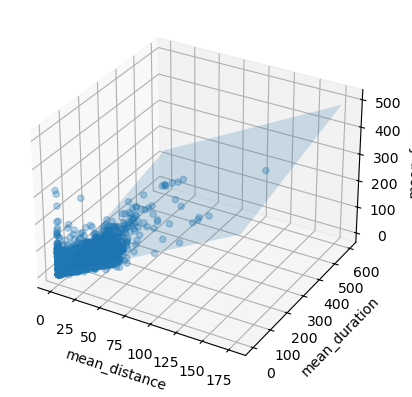

In [ ]:
X = df[["mean_distance", "mean_duration"]]
y = df["mean_fare"]

model = LinearRegression()
model.fit(X, y)

xx, yy = np.meshgrid(
    np.linspace(X["mean_distance"].min(), X["mean_distance"].max(), 50),
    np.linspace(X["mean_duration"].min(), X["mean_duration"].max(), 50)
)
zz = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

ax = plt.figure().add_subplot(111, projection="3d")
ax.scatter(X["mean_distance"], X["mean_duration"], y, alpha=0.3)
ax.plot_surface(xx, yy, zz, alpha=0.2)
ax.set_xlabel("mean_distance")
ax.set_ylabel("mean_duration")
ax.set_zlabel("mean_fare")
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = df[[
    "hour_sin",
    "hour_cos",
    "dow_sin",
    "dow_cos",
    "temperature_2m (°C)",
    "precipitation (mm)",
]].dropna()# const dazu
X_vif = X_vif.assign(const=1)
for i,col in enumerate(X_vif.columns):
    print(col, variance_inflation_factor(X_vif.values, i))

hour_sin 1.0490356336688829
hour_cos 1.0896856328645037
dow_sin 1.0099109139149665
dow_cos 1.000694430799181
temperature_2m (°C) 1.0766471260323427
precipitation (mm) 1.0086597553535748
const 3.4613184647730706


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/p

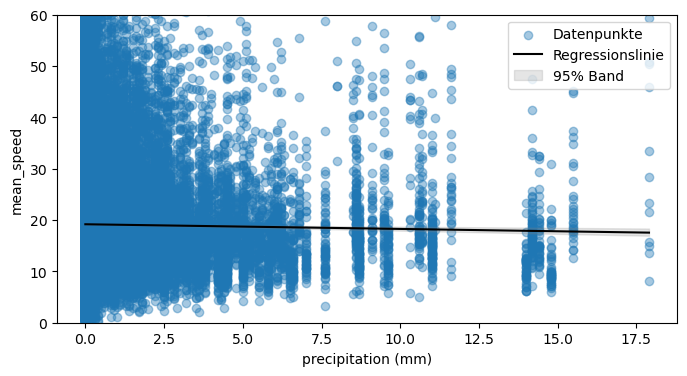

In [ ]:
# Daten auswählen und NaN entfernen
df2 = df[["precipitation (mm)", "mean_speed"]].dropna()

X = df2[["precipitation (mm)"]]
y = df2["mean_speed"]

# Modell fitten
model = LinearRegression()
model.fit(X, y)

# Linie erzeugen
x_grid = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
y_pred = model.predict(x_grid)

# Einfaches 95%-Konfidenzband via Bootstrapping
n_boot = 200
boot_preds = []

for _ in range(n_boot):
    samp = df2.sample(len(df2), replace=True)
    m = LinearRegression()
    m.fit(samp[["precipitation (mm)"]], samp["mean_speed"])
    boot_preds.append(m.predict(x_grid))

boot_preds = np.array(boot_preds)
lower = np.percentile(boot_preds, 2.5, axis=0)
upper = np.percentile(boot_preds,97.5, axis=0)

# Plot
fig, ax = plt.subplots(figsize=(8,4))

ax.scatter(X, y, alpha=0.4, label="Datenpunkte")
ax.plot(x_grid, y_pred, color="black", label="Regressionslinie")
ax.fill_between(x_grid.flatten(), lower, upper, color="gray", alpha=0.2, label="95% Band")
ax.set_ylim(0,60)
ax.set_xlabel("precipitation (mm)")
ax.set_ylabel("mean_speed")

ax.legend()
plt.show()

die Punktewolke zeigt, dass die mittlere Fahrgeschwindigkeit kaum systematisch mit Niederschlag zusammenhägt. die Regressionslinie liegt praktisch flach. Das bedeutet_ unter einer linearen Annahme ist der Effekt von Niederschlag auf die gEschwindigkeit sehr klein. Die sehr starke Streuung dominiert. Entsprechend ist der lineare Zusammenahng schwach. Das 95% Konfidenzban liegt so nahe an der Regressionlinie, dass es visuell kaum auffällt. Das passiert, wenn die geschätzte Steigung fast null ist.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/p

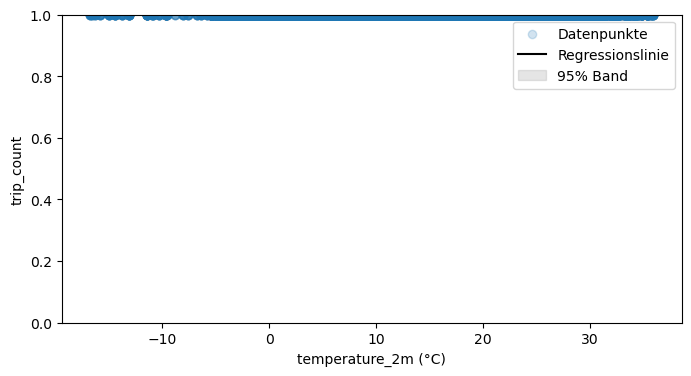

In [ ]:
# benötigte Spalten selektieren
df3 = df[["temperature_2m (°C)", "trip_count"]].dropna()

X = df3[["temperature_2m (°C)"]]
y = df3["trip_count"]

# lineares Modell fitten
model = LinearRegression()
model.fit(X, y)

x_grid = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
y_pred = model.predict(x_grid)

# 95 %-Konfidenzband via Bootstrap (didaktisch)
n_boot = 200
boot_preds = []

for _ in range(n_boot):
    samp = df3.sample(len(df3), replace=True)
    m = LinearRegression()
    m.fit(samp[["temperature_2m (°C)"]], samp["trip_count"])
    boot_preds.append(m.predict(x_grid))

boot_preds = np.array(boot_preds)
lower = np.percentile(boot_preds, 2.5, axis=0)
upper = np.percentile(boot_preds, 97.5, axis=0)

# Plot
fig, ax = plt.subplots(figsize=(8,4))

ax.scatter(X, y, alpha=0.2, label="Datenpunkte")
ax.plot(x_grid, y_pred, color="black", label="Regressionslinie")
ax.fill_between(x_grid.flatten(), lower, upper, color="gray", alpha=0.2,
                label="95% Band")

ax.set_xlabel("temperature_2m (°C)")
ax.set_ylabel("trip_count")


ax.legend()
plt.show()

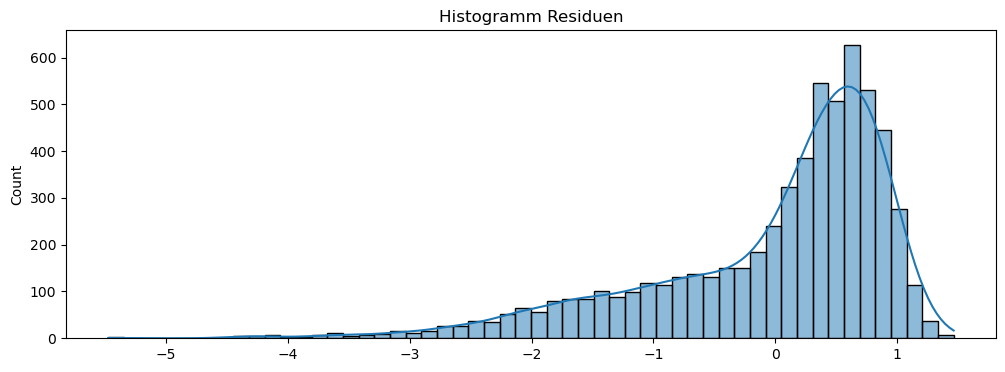

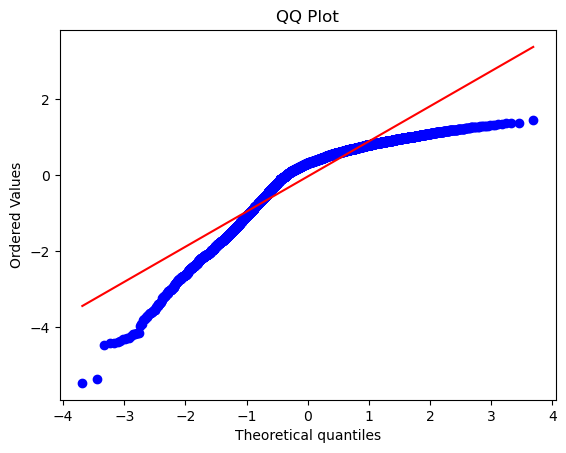

In [32]:
import seaborn as sns
import scipy.stats as stats

resid = y_test_log - y_hat_test_log

plt.figure(figsize=(12,4))
sns.histplot(resid, kde=True)
plt.title("Histogramm Residuen")
plt.show()

stats.probplot(resid, dist="norm", plot=plt)
plt.title("QQ Plot")
plt.show()

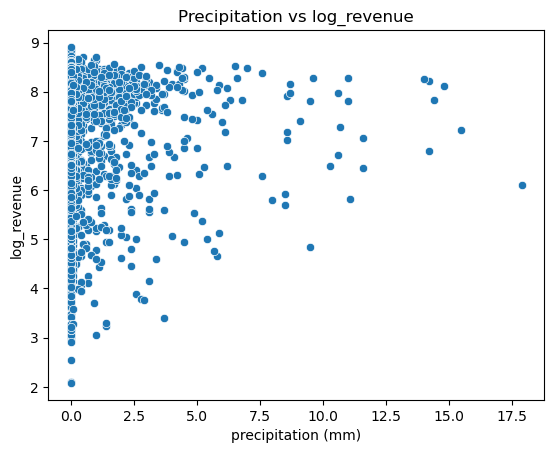

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=df["precipitation (mm)"], y=df["log_revenue"])
plt.title("Precipitation vs log_revenue")
plt.show()

# Conclusio

Wir haben herausgefunden, dass die trip_distance erwartungsgemäß der stärkste Prädiktor für den Fahrpreis (fare_amount) ist. Obwohl unser Datensatz eine hohe Varianz aufweist.

Wir haben zwei folgende Probleme identifiziert:
1. **Underfitting:**
Die einfache Regressionsgerade kann komplexe Tarifstrukturen wie die Grundgebühr, tageszeitabhängige Preisänderungen oder die Festpreise zu den Flughäfen nicht vollständig abbilden.
2. **Residuen Muster:** Die Untersuchung der Residuen hat gezeigt, dass die Vorhersagefehler nicht rein zufällig verteilt sind. Dies deutet auf Heteroskedastizität hin.